In [1]:
import cv2

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt

from scipy.linalg import qr
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('../Data/Original/data.csv')

In [33]:
def old_fourier(image):
    ham = np.hamming(224)[:, None] # 1D hamming
    ham2d = np.sqrt(np.dot(ham, ham.T))
    f = cv2.dft(image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
    f_shifted = np.fft.fftshift(f)
    f_complex = f_shifted[:,:,0]*1j + f_shifted[:,:,1]
    f_filtered = ham2d * f_complex
    f_filtered_shifted = np.fft.fftshift(f_filtered)
    inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
    filtered_img = np.abs(inv_img)
    filtered_img -= filtered_img.min()
    filtered_img = filtered_img*255 / filtered_img.max()
    filtered_img = filtered_img.astype(np.uint8)

    return filtered_img

def new_fourier(image):
    f = cv2.dft(image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
    f_shifted = np.fft.fftshift(f)
    filtered_real = top_bottom(f_shifted[:,:,1], 5)
    filtered_img  = top_bottom(f_shifted[:,:,0], 5)
    f_complex = filtered_img*1j + filtered_real
    f_filtered_shifted = np.fft.fftshift(f_complex)
    inv_img = np.fft.ifft2(f_filtered_shifted)
    filtered_img = np.abs(inv_img)
    filtered_img -= filtered_img.min()
    filtered_img = filtered_img*255 / filtered_img.max()
    filtered_img = filtered_img.astype(np.uint8)
    
    return filtered_img

def top_bottom(image, kernel_size):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_size,kernel_size))
    # Top Hat Transform
    topHat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
    # Black Hat Transform
    blackHat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)
    #Result
    filtered_img = image + topHat - blackHat
    
    return filtered_img

def top_hat(image, kernel_size):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_size,kernel_size))
    # Top Hat Transform
    topHat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
    
    filtered_img = image + topHat
    
    return filtered_img

def bottom_hat(image, kernel_size):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_size,kernel_size))
    # Black Hat Transform
    blackHat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)
    #Result
    filtered_img = image - blackHat
    
    return filtered_img

def clahe(image):
    clahe = cv2.createCLAHE()
    clahe_im = clahe.apply(image)

    return clahe_im

def hist_eq(image):
    return cv2.equalizeHist(image)

def godec(X, rank=1, card=None, iterated_power=1, max_iter=100, tol=0.001):
        i = 1
        RMSE = []
        card = np.prod(X.shape) if card is None else card

        X = X.T if(X.shape[0] < X.shape[1]) else X
        m, n = X.shape

        # Initialization of L and S
        L = X
        S = np.zeros(X.shape)
        LS = np.zeros(X.shape)

        while True:
            # Update of L
            Y2 = np.random.randn(n, rank)
            for i in range(iterated_power):
                Y1 = L.dot(Y2)
                Y2 = L.T.dot(Y1)
            Q, R = qr(Y2, mode='economic')
            L_new = (L.dot(Q)).dot(Q.T)

            # Update of S
            T = L - L_new + S
            L = L_new
            T_vec = T.reshape(-1)
            S_vec = S.reshape(-1)
            idx = abs(T_vec).argsort()[::-1]
            S_vec[idx[:card]] = T_vec[idx[:card]]
            S = S_vec.reshape(S.shape)

            # Reconstruction
            LS = L + S

            # Stopping criteria
            error = np.sqrt(mean_squared_error(X, LS))
            RMSE.append(error)

            #print("iter: ", iter, "error: ", error)
            if (error <= tol) or (i >= max_iter):
                break
            else:
                i += 1

        return L, S, LS, RMSE
    
def gfourier(image):
    image = clahe(image)

    f = cv2.dft(image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
    f_shifted = np.fft.fftshift(f)
    filtered_real = top_bottom(f_shifted[:,:,1], 3)
    filtered_img  = top_bottom(f_shifted[:,:,0], 3)
    f_complex = filtered_img*1j + filtered_real
    f_filtered_shifted = np.fft.fftshift(f_complex)
    inv_img = np.fft.ifft2(f_filtered_shifted)
    filtered_img = np.abs(inv_img)
    filtered_img -= filtered_img.min()
    filtered_img = filtered_img*255 / filtered_img.max()
    filtered_img = filtered_img.astype(np.uint8)
    
    _, filtered_img, _, _ = godec(filtered_img)
    
    return filtered_img

In [ ]:
def proposed_1(image):
    _, image, _, _ = godec(image)

    f = cv2.dft(image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
    f_shifted = np.fft.fftshift(f)
    filtered_real = top_bottom(f_shifted[:,:,1], 3)
    filtered_img  = top_bottom(f_shifted[:,:,0], 3)
    f_complex = filtered_img*1j + filtered_real
    f_filtered_shifted = np.fft.fftshift(f_complex)
    inv_img = np.fft.ifft2(f_filtered_shifted)
    filtered_img = np.abs(inv_img)
    filtered_img -= filtered_img.min()
    filtered_img = filtered_img*255 / filtered_img.max()
    filtered_img = filtered_img.astype(np.uint8)
    
    filtered_img = clahe(filtered_img)
    return filtered_img

In [ ]:
def proposed_2(image):
    image = clahe(image)

    f = cv2.dft(image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
    f_shifted = np.fft.fftshift(f)
    filtered_real = top_bottom(f_shifted[:,:,1], 3)
    filtered_img  = top_bottom(f_shifted[:,:,0], 3)
    f_complex = filtered_img*1j + filtered_real
    f_filtered_shifted = np.fft.fftshift(f_complex)
    inv_img = np.fft.ifft2(f_filtered_shifted)
    filtered_img = np.abs(inv_img)
    filtered_img -= filtered_img.min()
    filtered_img = filtered_img*255 / filtered_img.max()
    filtered_img = filtered_img.astype(np.uint8)
    
    _, filtered_img, _, _ = godec(filtered_img)
    
    return filtered_img

In [1]:
def show_results(image, filtered_image):
    plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('original')

    plt.subplot(122)
    plt.imshow(filtered_image, cmap='gray')
    plt.title('filtered');

In [20]:
idx = 1000

image = cv2.imread('D:\Graduation Project\Data\\'+data.iloc[idx, 0], 0)
image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_AREA)

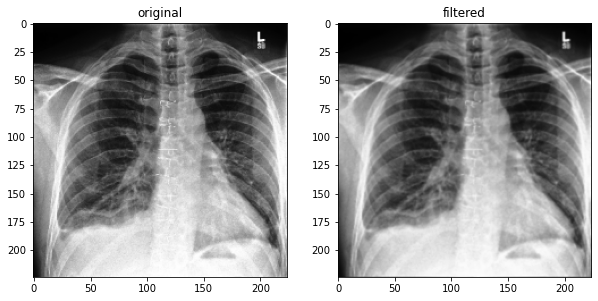

In [6]:
filtered_image = old_fourier(image)

show_results(image, filtered_image)

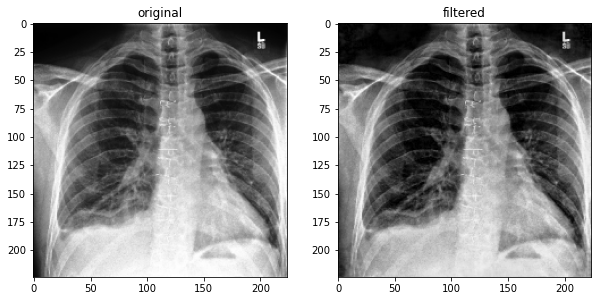

In [7]:
filtered_image = new_fourier(image)

show_results(image, filtered_image)

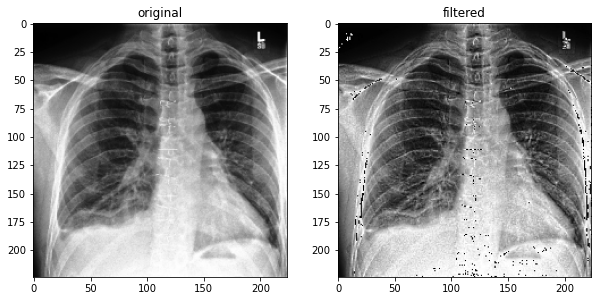

In [8]:
filtered_image = top_bottom(image, 3)

show_results(image, filtered_image)

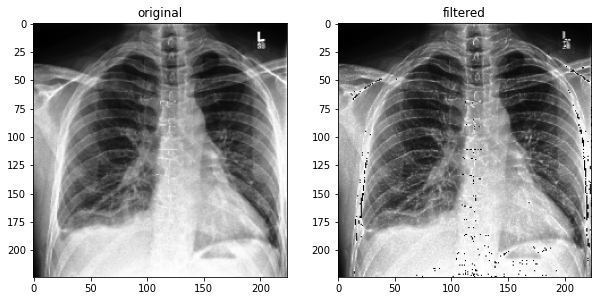

In [9]:
filtered_image = top_hat(image, 3)

show_results(image, filtered_image)

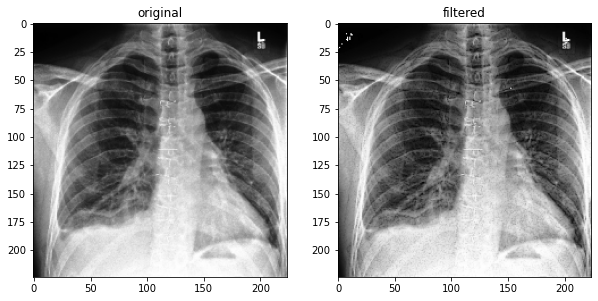

In [10]:
filtered_image = bottom_hat(image, 3)

show_results(image, filtered_image)

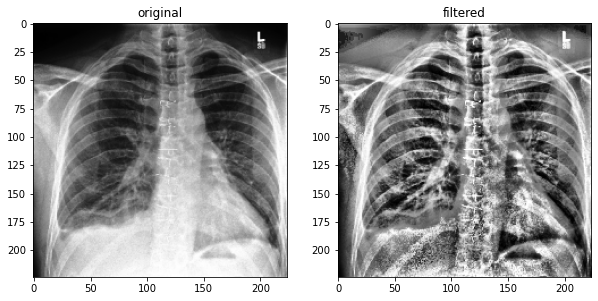

In [11]:
filtered_image = clahe(image)

show_results(image, filtered_image)

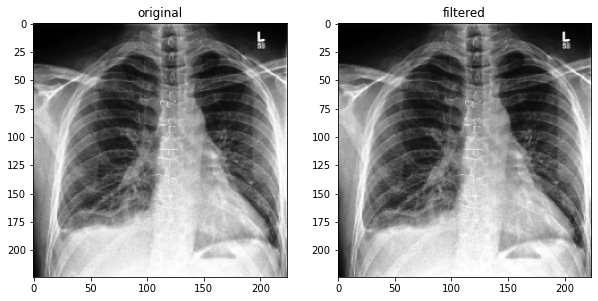

In [12]:
filtered_image = hist_eq(image)

show_results(image, filtered_image)

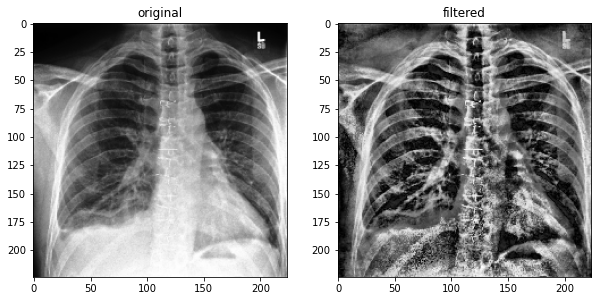

In [13]:
filtered_image = new_fourier(clahe(image))     # proposed filter

show_results(image, filtered_image)

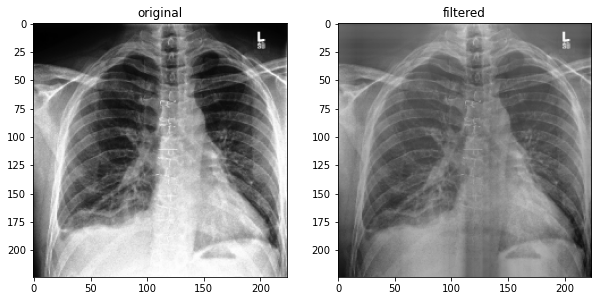

In [19]:
L, S, LS, RMSE = godec(image)
filtered_image = S.astype(np.float32)

show_results(image, filtered_image)

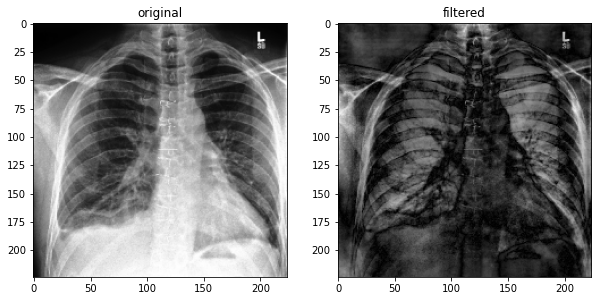

In [10]:
filtered_image = gfourier(image)

show_results(image, filtered_image)

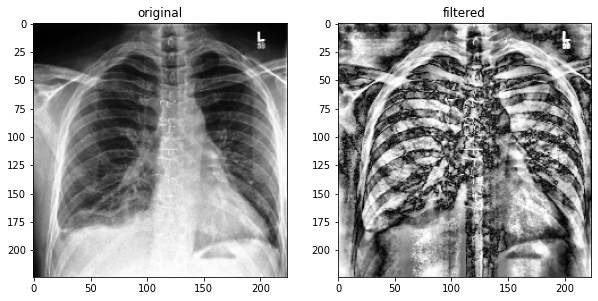

In [31]:
filtered_image = proposed_1(image)

show_results(image, filtered_image)

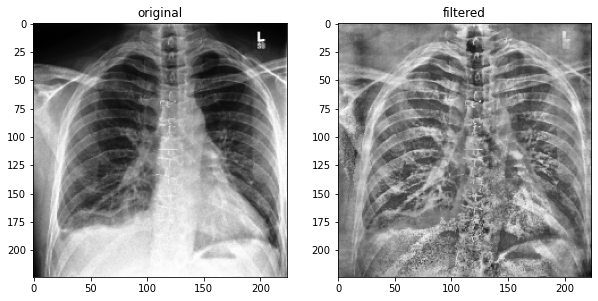

In [34]:
filtered_image = gfourier(image)

show_results(image, filtered_image)

# Choosing top-5

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re

In [27]:
results = pd.read_excel('../../../../Our Paper/Results_4.xlsx')

In [28]:
results_no_attention = results.iloc[:-3, :]

In [29]:
results_no_attention.groupby('Image size')['Average'].mean()

Image size
224.0    0.894486
256.0    0.895814
320.0    0.899432
Name: Average, dtype: float64

In [30]:
results.groupby('Image size')['Average'].mean()

Image size
224.0    0.889112
256.0    0.895814
320.0    0.899432
Name: Average, dtype: float64

In [31]:
# Cardio
results.groupby('Image size')['Cardiomegaly'].mean()

Image size
224.0    0.845124
256.0    0.848204
320.0    0.859535
Name: Cardiomegaly, dtype: float64

In [32]:
# Edema
results.groupby('Image size')['Edema'].mean()

Image size
224.0    0.926562
256.0    0.936968
320.0    0.938159
Name: Edema, dtype: float64

In [33]:
# Consolidation
results.groupby('Image size')['Consolidation'].mean()

Image size
224.0    0.920198
256.0    0.924974
320.0    0.925718
Name: Consolidation, dtype: float64

In [34]:
# Atelectasis
results.groupby('Image size')['Atelectasis'].mean()

Image size
224.0    0.829794
256.0    0.839195
320.0    0.844859
Name: Atelectasis, dtype: float64

In [35]:
# Pleural Effusion
results.groupby('Image size')['Pleural Effusion'].mean()

Image size
224.0    0.923880
256.0    0.929731
320.0    0.928879
Name: Pleural Effusion, dtype: float64

### Best

In [36]:
diseases = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']

_224_

In [37]:
size_224 = results[results['Image size']==224].copy()

In [38]:
size_224

,Model Name,#Parameters,Image size,Batch size,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,Average
0,"ResNet-18 ( He, et al, 2016)",11179077.0,224.0,64.0,0.858177,0.920089,0.921691,0.835906,0.913610,0.889895
3,"ResNet-34 ( He, et al, 2016)",21287237.0,224.0,64.0,0.858846,0.935714,0.925368,0.814488,0.924706,0.891824
6,"ResNet-50 ( He, et al, 2016)",23518277.0,224.0,64.0,0.842580,0.919196,0.921140,0.823412,0.942369,0.889739
9,"ResNet-101 ( He, et al, 2016)",42510405.0,224.0,64.0,0.871324,0.934524,0.916728,0.797900,0.935688,0.891233
12,"ResNet-152 ( He, et al, 2016)",58154053.0,224.0,64.0,0.879345,0.920089,0.917831,0.857008,0.919158,0.898686
15,"Inception_v4 ( Szegedy, et al, 2017)",41150501.0,224.0,64.0,0.844029,0.944940,0.931618,0.861837,0.922328,0.900950
18,"Xception (Chollet, et al, 2017)",20817197.0,224.0,64.0,0.855615,0.912351,0.920956,0.850289,0.945312,0.896905
21,"Inception_ResNet_v2 (Szegedy, Christian, et al...",54314149.0,224.0,64.0,0.851604,0.916220,0.921875,0.830026,0.924932,0.888932
24,"MobileNet_v2 ( Sandler, et al, 2018)",4556549.0,224.0,64.0,0.854055,0.945387,0.906250,0.813753,0.943274,0.892544
27,"MobileNet_v3 ( Howard, et al, 2019)",4208437.0,224.0,64.0,0.862634,0.928571,0.909375,0.836745,0.937274,0.894920


In [39]:
size_224.iloc[:-3, 4:].mean(axis=0)

Cardiomegaly        0.852140
Edema               0.931540
Consolidation       0.924667
Atelectasis         0.832826
Pleural Effusion    0.931257
Average             0.894486
dtype: float64

In [40]:
size_224.iloc[:-3, 4:].max(axis=0)

Cardiomegaly        0.879345
Edema               0.945387
Consolidation       0.945037
Atelectasis         0.865827
Pleural Effusion    0.945312
Average             0.909180
dtype: float64

In [41]:
size_224.to_csv('224_size.csv', index=False)

In [42]:
size_224.iloc[:-3, 4:].mean()[:-1].mean()

0.8944860666666667

In [43]:
avg_224 = 0
for d in diseases:
    avg_224 += size_224[d].max()
    print(size_224[d].max())
    
print('===========')
print(avg_224/5)

0.879345
0.945387
0.945037
0.865827
0.945312
0.9161816


In [44]:
size_224[(size_224['Cardiomegaly']==0.879345)|(size_224['Edema']==0.945387)|(size_224['Consolidation']==0.945037)|
         (size_224['Atelectasis']==0.865827)|(size_224['Pleural Effusion']==0.945312)].loc[[12, 24, 57, 54, 18], :]

,Model Name,#Parameters,Image size,Batch size,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,Average
12,"ResNet-152 ( He, et al, 2016)",58154053.0,224.0,64.0,0.879345,0.920089,0.917831,0.857008,0.919158,0.898686
24,"MobileNet_v2 ( Sandler, et al, 2018)",4556549.0,224.0,64.0,0.854055,0.945387,0.906250,0.813753,0.943274,0.892544
57,"DenseNet-201 ( Lu, et al, 2021)",18098565.0,224.0,64.0,0.830102,0.936161,0.945037,0.836220,0.935462,0.896596
54,"DenseNet-161 ( Celik, et al, 2020)",26478437.0,224.0,64.0,0.834559,0.919048,0.931985,0.865827,0.925838,0.895451
18,"Xception (Chollet, et al, 2017)",20817197.0,224.0,64.0,0.855615,0.912351,0.920956,0.850289,0.945312,0.896905


In [45]:
models_names = size_224['Model Name'].str.extract('(.* \()')[0].str[:-2][:-3].values
models_names

array(['ResNet-18', 'ResNet-34', 'ResNet-50', 'ResNet-101', 'ResNet-152',
       'Inception_v4', 'Xception', 'Inception_ResNet_v2', 'MobileNet_v2',
       'MobileNet_v3', 'EfficientNet-B0', 'EfficientNet-B1',
       'EfficientNet-B2 ', 'EfficientNet-B3 ', 'EfficientNet-B4',
       'EfficientNet_v2', 'ReXNet', 'DenseNet-121', 'DenseNet-161',
       'DenseNet-201', 'DenseNet-169'], dtype=object)

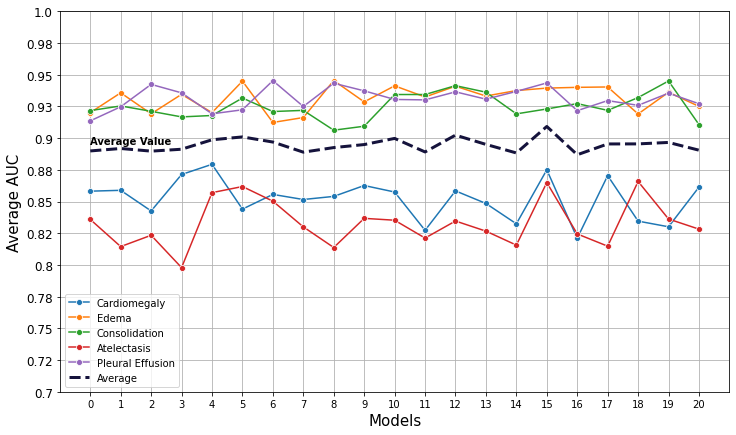

In [64]:
plt.figure(figsize=(12, 7))
for d in diseases:
    sns.lineplot(x=range(size_224.shape[0])[:-3], y=size_224[d][:-3], label=d, marker='o')
    
sns.lineplot(x=range(size_224.shape[0])[:-3], y=size_224['Average'][:-3], label='Average', linewidth=3, color='#15133C', linestyle='dashed');

plt.text(0, 0.895, 'Average Value', fontsize=10, weight='bold')
#plt.title('Figure (??) Models Behaviour over size of 224', fontsize=20, color='brown', y=-0.2)
plt.xlabel('Models', fontsize=15)
plt.xticks(range(size_224.shape[0])[:-3], range(size_224.shape[0])[:-3])
#plt.xticks(range(size_224.shape[0])[:-3], models_names, rotation=90, fontsize=12)
plt.ylabel('Average AUC', fontsize=15)
plt.yticks(np.arange(.7, 1.00, .025), [round(x, 2) for x in np.arange(.7, 1.00, .025)], fontsize=12)
plt.grid()
plt.savefig('D Vs M 224', bbox_inches='tight');

_256_

In [49]:
size_256 = results[results['Image size']==256].copy()

In [50]:
size_256

,Model Name,#Parameters,Image size,Batch size,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,Average
1,NaN,11179077.0,256.0,64.0,0.866644,0.931696,0.918566,0.820997,0.942595,0.896100
4,NaN,21287237.0,256.0,64.0,0.862857,0.937500,0.916176,0.828451,0.925385,0.894074
7,NaN,23518277.0,256.0,64.0,0.857732,0.930506,0.920588,0.844094,0.924026,0.895389
10,NaN,42510405.0,256.0,64.0,0.855949,0.927827,0.924265,0.835276,0.938745,0.896412
13,NaN,58154053.0,256.0,64.0,0.855169,0.941815,0.915257,0.822152,0.935122,0.893903
16,NaN,41150501.0,256.0,64.0,0.850045,0.943750,0.943566,0.844304,0.929801,0.902293
19,NaN,20817197.0,256.0,64.0,0.815954,0.930208,0.923346,0.856168,0.936821,0.892499
22,NaN,54314149.0,256.0,64.0,0.824866,0.929613,0.927574,0.848609,0.928555,0.891843
25,NaN,4556549.0,256.0,64.0,0.848819,0.954762,0.931066,0.842940,0.917912,0.899100
28,NaN,4208437.0,256.0,64.0,0.829211,0.944792,0.926287,0.836220,0.915761,0.890454


In [51]:
size_256.iloc[:, 4:].mean(axis=0)

Cardiomegaly        0.848204
Edema               0.936968
Consolidation       0.924974
Atelectasis         0.839195
Pleural Effusion    0.929731
Average             0.895814
dtype: float64

In [52]:
size_256.to_csv('256_size.csv', index=False)

In [53]:
avg_256 = 0
for d in diseases:
    avg_256 += size_256[d].max()
    print(size_256[d].max())
    
print('===========')
print(avg_256/5)

0.883578
0.954762
0.944853
0.862467
0.948936
0.9189192


In [54]:
size_256[(size_256['Cardiomegaly']==0.883578)|(size_256['Edema']==0.954762)|(size_256['Consolidation']==0.944853)|
         (size_256['Atelectasis']==0.862467)|(size_256['Pleural Effusion']==0.948936)].loc[[40, 25, 31, 61], :]

,Model Name,#Parameters,Image size,Batch size,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,Average
40,NaN,10703917.0,256.0,64.0,0.883578,0.937798,0.930699,0.852388,0.931386,0.907170
25,NaN,4556549.0,256.0,64.0,0.848819,0.954762,0.931066,0.842940,0.917912,0.899100
31,NaN,4013953.0,256.0,64.0,0.833556,0.946280,0.944853,0.840315,0.921082,0.897217
61,NaN,12489349.0,256.0,64.0,0.811163,0.931250,0.925735,0.862467,0.948936,0.895910


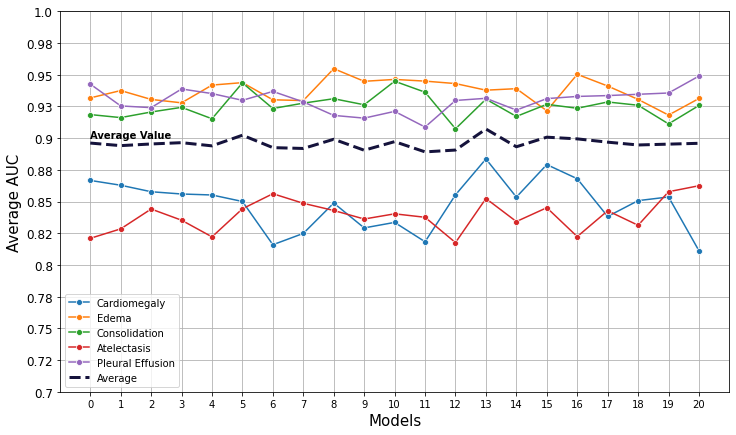

In [65]:
plt.figure(figsize=(12, 7))
for d in diseases:
    sns.lineplot(x=range(size_256.shape[0]), y=size_256[d], label=d, marker='o');

sns.lineplot(x=range(size_256.shape[0]), y=size_256['Average'], label='Average', linewidth=3, color='#15133C', linestyle='dashed');

plt.text(0, 0.9, 'Average Value', fontsize=10, weight='bold')
#plt.title('Figure (??) Models Behaviour over size of 256', fontsize=20, color='brown', y=-0.2)
plt.xlabel('Models', fontsize=15)
plt.xticks(range(size_256.shape[0]), range(size_256.shape[0]))
plt.ylabel('Average AUC', fontsize=15)
plt.yticks(np.arange(.7, 1.00, .025), [round(x, 2) for x in np.arange(.7, 1.00, .025)], fontsize=12)
plt.grid()
plt.savefig('D Vs M 256', bbox_inches='tight');

_320_

In [57]:
size_320 = results[results['Image size']==320].copy()

In [58]:
size_320

,Model Name,#Parameters,Image size,Batch size,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,Average
2,NaN,11179077.0,320.0,32.0,0.858846,0.917411,0.925551,0.867507,0.930933,0.900050
5,NaN,21287237.0,320.0,32.0,0.864082,0.934226,0.913419,0.837690,0.927536,0.895391
8,NaN,23518277.0,320.0,32.0,0.841689,0.931845,0.942463,0.879055,0.933877,0.905786
11,NaN,42510405.0,320.0,32.0,0.868873,0.922768,0.909926,0.862887,0.921309,0.897153
14,NaN,58154053.0,320.0,32.0,0.864416,0.937649,0.949265,0.854278,0.925611,0.906244
17,NaN,41150501.0,320.0,32.0,0.861297,0.943452,0.925919,0.820787,0.924366,0.895200
20,NaN,20817197.0,320.0,32.0,0.847148,0.936458,0.918199,0.843990,0.932178,0.895595
23,NaN,54314149.0,320.0,32.0,0.861742,0.930060,0.925184,0.853123,0.935915,0.901205
26,NaN,4556549.0,320.0,32.0,0.861074,0.936012,0.932721,0.837165,0.931499,0.899694
29,NaN,4208437.0,320.0,32.0,0.896502,0.938839,0.894485,0.833596,0.930593,0.898803


In [59]:
size_320.to_csv('320_size.csv', index=False)

In [60]:
size_320.iloc[:, 4:].mean(axis=0)

Cardiomegaly        0.859535
Edema               0.938159
Consolidation       0.925718
Atelectasis         0.844859
Pleural Effusion    0.928879
Average             0.899432
dtype: float64

In [61]:
avg_320 = 0
for d in diseases:
    avg_320 += size_320[d].max()
    print(size_320[d].max())
    
print('===========')
print(avg_320/5)

0.896502
0.952083
0.949265
0.879055
0.939425
0.9232659999999999


In [62]:
size_320[(size_320['Cardiomegaly']==0.896502)|(size_320['Edema']==0.952083)|(size_320['Consolidation']==0.949265)|
         (size_320['Atelectasis']==0.879055)|(size_320['Pleural Effusion']==0.939425)].loc[[29, 50, 14, 8, 56], :]

,Model Name,#Parameters,Image size,Batch size,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,Average
29,NaN,4208437.0,320.0,32.0,0.896502,0.938839,0.894485,0.833596,0.930593,0.898803
50,NaN,3522278.0,320.0,32.0,0.834225,0.952083,0.927206,0.841575,0.930593,0.897136
14,NaN,58154053.0,320.0,32.0,0.864416,0.937649,0.949265,0.854278,0.925611,0.906244
8,NaN,23518277.0,320.0,32.0,0.841689,0.931845,0.942463,0.879055,0.933877,0.905786
56,NaN,26478437.0,320.0,32.0,0.850379,0.944048,0.937132,0.827087,0.939425,0.899614


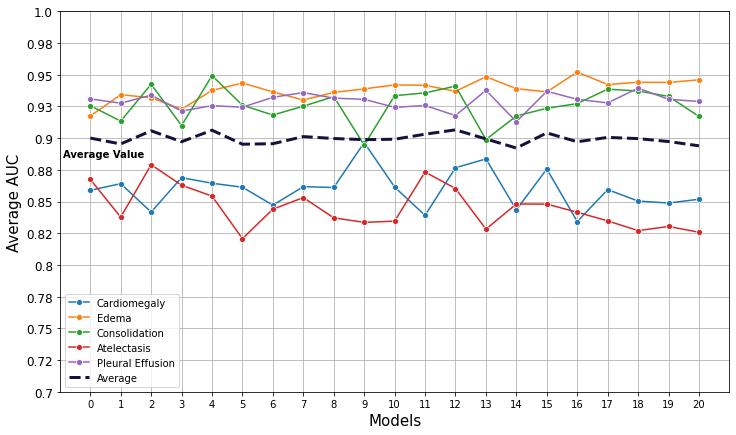

In [66]:
plt.figure(figsize=(12, 7))
for d in diseases:
    sns.lineplot(x=range(size_320.shape[0]), y=size_320[d], label=d, marker='o');

sns.lineplot(x=range(size_320.shape[0]), y=size_320['Average'], label='Average', linewidth=3, color='#15133C', linestyle='dashed');

plt.text(-0.9, 0.885, 'Average Value', fontsize=10, weight='bold')
#plt.title('Figure (??) Models Behaviour over size of 320', fontsize=20, color='brown', y=-0.2)
plt.xlabel('Models', fontsize=15)
plt.xticks(range(size_320.shape[0]), range(size_320.shape[0]))
plt.ylabel('Average AUC', fontsize=15)
plt.yticks(np.arange(.7, 1.00, .025), [round(x, 2) for x in np.arange(.7, 1.00, .025)], fontsize=12)
plt.grid()
plt.savefig('D Vs M 320', bbox_inches='tight');

#### Splitting 

In [29]:
results.head()

,Model Name,#Parameters,Image size,Batch size,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,Average
0,"ResNet-18 ( He, et al, 2016)",11179077,224,64,0.858177,0.920089,0.921691,0.835906,0.913610,0.889895
1,"ResNet-18 ( He, et al, 2016)",11179077,256,64,0.866644,0.931696,0.918566,0.820997,0.942595,0.896100
2,"ResNet-18 ( He, et al, 2016)",11179077,320,32,0.858846,0.917411,0.925551,0.867507,0.930933,0.900050
3,"ResNet-34 ( He, et al, 2016)",21287237,224,64,0.858846,0.935714,0.925368,0.814488,0.924706,0.891824
4,"ResNet-34 ( He, et al, 2016)",21287237,256,64,0.862857,0.937500,0.916176,0.828451,0.925385,0.894074


In [30]:
results.tail()

,Model Name,#Parameters,Image size,Batch size,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,Average
61,"DenseNet-169 ( Vulli, et al, 2022)",12489349,256,64,0.811163,0.931250,0.925735,0.862467,0.948936,0.895910
62,"DenseNet-169 ( Vulli, et al, 2022)",12489349,320,32,0.851827,0.945982,0.917096,0.825827,0.928895,0.893925
63,"ViT (Dosovitskiy, et al, 2020)",85650437,224,64,0.720811,0.857292,0.832353,0.757795,0.782043,0.790059
64,"CoaT (Xu, et al,2021)",16218673,224,64,0.820410,0.882887,0.906434,0.829291,0.904438,0.868692
65,"ConvNeXt (Liu, et al,2022)",87553541,224,64,0.846814,0.934970,0.927941,0.838635,0.930254,0.895723


In [31]:
# results.drop('#Parameters', axis=1, inplace=True)
# results.fillna(0, inplace=True)
# results.dropna(inplace=True)

In [32]:
results.sort_values(by='Cardiomegaly', ascending=False).head(10)

,Model Name,#Parameters,Image size,Batch size,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,Average
29,"MobileNet_v3 ( Howard, et al, 2019)",4208437,320,32,0.896502,0.938839,0.894485,0.833596,0.930593,0.898803
41,"EfficientNet-B3 (Tan,, et al, 2019)",10703917,320,32,0.883578,0.948363,0.898897,0.828241,0.937726,0.899361
40,"EfficientNet-B3 (Tan,, et al, 2019)",10703917,256,64,0.883578,0.937798,0.930699,0.852388,0.931386,0.907170
12,"ResNet-152 ( He, et al, 2016)",58154053,224,64,0.879345,0.920089,0.917831,0.857008,0.919158,0.898686
46,"EfficientNet_v2 (Tan,, et al, 2021)",22157261,256,64,0.879122,0.921577,0.926654,0.845144,0.931159,0.900732
38,"EfficientNet-B2 (Tan,, et al, 2019)",7708039,320,32,0.876671,0.936905,0.940993,0.860262,0.917799,0.906526
47,"EfficientNet_v2 (Tan,, et al, 2021)",22157261,320,32,0.875668,0.936458,0.923529,0.847979,0.936934,0.904114
45,"EfficientNet_v2 (Tan,, et al, 2021)",22157261,224,64,0.875000,0.939435,0.922978,0.864987,0.943501,0.909180
9,"ResNet-101 ( He, et al, 2016)",42510405,224,64,0.871324,0.934524,0.916728,0.797900,0.935688,0.891233
51,"DenseNet-121 ( Solano-Rojas , et al, 2020)",6956805,224,64,0.870432,0.940327,0.921875,0.814803,0.929574,0.895402


In [33]:
results.sort_values(by='Edema', ascending=False).head(10)

,Model Name,#Parameters,Image size,Batch size,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,Average
25,"MobileNet_v2 ( Sandler, et al, 2018)",4556549,256,64,0.848819,0.954762,0.931066,0.842940,0.917912,0.899100
50,"ReXNet (Han, et al, 2021)",3522278,320,32,0.834225,0.952083,0.927206,0.841575,0.930593,0.897136
49,"ReXNet (Han, et al, 2021)",3522278,256,64,0.867981,0.950298,0.923529,0.822362,0.932858,0.899406
41,"EfficientNet-B3 (Tan,, et al, 2019)",10703917,320,32,0.883578,0.948363,0.898897,0.828241,0.937726,0.899361
31,"EfficientNet-B0 (Tan,, et al, 2019)",4013953,256,64,0.833556,0.946280,0.944853,0.840315,0.921082,0.897217
62,"DenseNet-169 ( Vulli, et al, 2022)",12489349,320,32,0.851827,0.945982,0.917096,0.825827,0.928895,0.893925
24,"MobileNet_v2 ( Sandler, et al, 2018)",4556549,224,64,0.854055,0.945387,0.906250,0.813753,0.943274,0.892544
34,"EfficientNet-B1 (Tan,, et al, 2019)",6519589,256,64,0.818293,0.944940,0.936213,0.837585,0.908741,0.889155
15,"Inception_v4 ( Szegedy, et al, 2017)",41150501,224,64,0.844029,0.944940,0.931618,0.861837,0.922328,0.900950
28,"MobileNet_v3 ( Howard, et al, 2019)",4208437,256,64,0.829211,0.944792,0.926287,0.836220,0.915761,0.890454


In [34]:
results.sort_values(by='Consolidation', ascending=False).head(10)

,Model Name,#Parameters,Image size,Batch size,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,Average
14,"ResNet-152 ( He, et al, 2016)",58154053,320,32,0.864416,0.937649,0.949265,0.854278,0.925611,0.906244
57,"DenseNet-201 ( Lu, et al, 2021)",18098565,224,64,0.830102,0.936161,0.945037,0.836220,0.935462,0.896596
31,"EfficientNet-B0 (Tan,, et al, 2019)",4013953,256,64,0.833556,0.946280,0.944853,0.840315,0.921082,0.897217
16,"Inception_v4 ( Szegedy, et al, 2017)",41150501,256,64,0.850045,0.943750,0.943566,0.844304,0.929801,0.902293
8,"ResNet-50 ( He, et al, 2016)",23518277,320,32,0.841689,0.931845,0.942463,0.879055,0.933877,0.905786
36,"EfficientNet-B2 (Tan,, et al, 2019)",7708039,224,64,0.858400,0.940923,0.941360,0.834646,0.936481,0.902360
38,"EfficientNet-B2 (Tan,, et al, 2019)",7708039,320,32,0.876671,0.936905,0.940993,0.860262,0.917799,0.906526
53,"DenseNet-121 ( Solano-Rojas , et al, 2020)",6956805,320,32,0.859403,0.942262,0.938603,0.834751,0.927763,0.900556
56,"DenseNet-161 ( Celik, et al, 2020)",26478437,320,32,0.850379,0.944048,0.937132,0.827087,0.939425,0.899614
34,"EfficientNet-B1 (Tan,, et al, 2019)",6519589,256,64,0.818293,0.944940,0.936213,0.837585,0.908741,0.889155


In [35]:
results.sort_values(by='Atelectasis', ascending=False).head(10)

,Model Name,#Parameters,Image size,Batch size,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,Average
8,"ResNet-50 ( He, et al, 2016)",23518277,320,32,0.841689,0.931845,0.942463,0.879055,0.933877,0.905786
35,"EfficientNet-B1 (Tan,, et al, 2019)",6519589,320,32,0.839127,0.941667,0.935662,0.873281,0.925725,0.903092
2,"ResNet-18 ( He, et al, 2016)",11179077,320,32,0.858846,0.917411,0.925551,0.867507,0.930933,0.900050
54,"DenseNet-161 ( Celik, et al, 2020)",26478437,224,64,0.834559,0.919048,0.931985,0.865827,0.925838,0.895451
45,"EfficientNet_v2 (Tan,, et al, 2021)",22157261,224,64,0.875000,0.939435,0.922978,0.864987,0.943501,0.909180
11,"ResNet-101 ( He, et al, 2016)",42510405,320,32,0.868873,0.922768,0.909926,0.862887,0.921309,0.897153
61,"DenseNet-169 ( Vulli, et al, 2022)",12489349,256,64,0.811163,0.931250,0.925735,0.862467,0.948936,0.895910
15,"Inception_v4 ( Szegedy, et al, 2017)",41150501,224,64,0.844029,0.944940,0.931618,0.861837,0.922328,0.900950
38,"EfficientNet-B2 (Tan,, et al, 2019)",7708039,320,32,0.876671,0.936905,0.940993,0.860262,0.917799,0.906526
58,"DenseNet-201 ( Lu, et al, 2021)",18098565,256,64,0.853610,0.918155,0.911213,0.857743,0.935575,0.895259


In [36]:
results.sort_values(by='Pleural Effusion', ascending=False).head(10)

,Model Name,#Parameters,Image size,Batch size,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,Average
61,"DenseNet-169 ( Vulli, et al, 2022)",12489349,256,64,0.811163,0.931250,0.925735,0.862467,0.948936,0.895910
18,"Xception (Chollet, et al, 2017)",20817197,224,64,0.855615,0.912351,0.920956,0.850289,0.945312,0.896905
45,"EfficientNet_v2 (Tan,, et al, 2021)",22157261,224,64,0.875000,0.939435,0.922978,0.864987,0.943501,0.909180
24,"MobileNet_v2 ( Sandler, et al, 2018)",4556549,224,64,0.854055,0.945387,0.906250,0.813753,0.943274,0.892544
1,"ResNet-18 ( He, et al, 2016)",11179077,256,64,0.866644,0.931696,0.918566,0.820997,0.942595,0.896100
6,"ResNet-50 ( He, et al, 2016)",23518277,224,64,0.842580,0.919196,0.921140,0.823412,0.942369,0.889739
56,"DenseNet-161 ( Celik, et al, 2020)",26478437,320,32,0.850379,0.944048,0.937132,0.827087,0.939425,0.899614
10,"ResNet-101 ( He, et al, 2016)",42510405,256,64,0.855949,0.927827,0.924265,0.835276,0.938745,0.896412
41,"EfficientNet-B3 (Tan,, et al, 2019)",10703917,320,32,0.883578,0.948363,0.898897,0.828241,0.937726,0.899361
27,"MobileNet_v3 ( Howard, et al, 2019)",4208437,224,64,0.862634,0.928571,0.909375,0.836745,0.937274,0.894920


# Not Clean Analysis

In [1]:
import pandas as pd

In [2]:
not_clean = pd.read_csv('../../../Both/Data/Final Data/clean data/not_clean_4.csv')

In [3]:
not_clean.shape

(302, 7)

In [4]:
not_clean.head()

,Path,Frontal/Lateral,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
0,CheXpert-v1.0-small/train/patient00052/study1/...,Lateral,-1.0,0.0,-1.0,-1.0,1.0
1,CheXpert-v1.0-small/train/patient00178/study10...,Lateral,0.0,0.0,0.0,0.0,0.0
2,CheXpert-v1.0-small/train/patient00216/study1/...,Frontal,0.0,0.0,0.0,0.0,0.0
3,CheXpert-v1.0-small/train/patient00260/study1/...,Frontal,0.0,0.0,0.0,1.0,1.0
4,CheXpert-v1.0-small/train/patient00294/study4/...,Frontal,-1.0,1.0,-1.0,-1.0,0.0


In [5]:
not_clean.loc[:, not_clean.columns[2:]] = not_clean.loc[:, not_clean.columns[2:]].fillna(0)

zeros = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']
not_clean.loc[:, zeros] = not_clean.loc[:, zeros].replace({-1:0})
ones = ['Edema', 'Atelectasis']
not_clean.loc[:, ones] = not_clean.loc[:, ones].replace({-1:1})

In [6]:
not_clean.iloc[:, 2:].sum(axis=0)

Cardiomegaly         40.0
Edema                66.0
Consolidation        23.0
Atelectasis          89.0
Pleural Effusion    126.0
dtype: float64

# Clean data

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
clean_data = pd.read_csv('../Data/clean/clean_data.csv')

In [4]:
clean_data[(clean_data['Frontal/Lateral']=='Frontal')&(clean_data['Label']==1)].shape

(4171, 20)

In [6]:
not_clean = clean_data[(clean_data['Frontal/Lateral']=='Frontal')&(clean_data['Label']==1)].copy()

In [ ]:
for i in range(not_clean.shape[0]):
    plt.imshow(plt.imread('D:\Graduation Project\Data\\'+not_clean.iloc[i, 0]), cmap='gray')
    plt.show()

In [ ]:
not_clean.to_csv('../Data/clean/not_clean.csv')

# New Filter

In [2]:
import cv2

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from scipy.linalg import qr
from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_csv('../../../Both/Data/Final Data/clean data/clean_2.csv')

In [4]:
def top_bottom(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    # Top Hat Transform
    topHat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
    # Black Hat Transform
    blackHat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)
    #Result
    filtered_img = image + topHat - blackHat
    
    return filtered_img

def clahe(image):
    clahe = cv2.createCLAHE()
    clahe_im = clahe.apply(image)

    return clahe_im

def godec(X, rank=1, card=None, iterated_power=1, max_iter=100, tol=0.001):
        i = 1
        RMSE = []
        card = np.prod(X.shape) if card is None else card

        X = X.T if(X.shape[0] < X.shape[1]) else X
        m, n = X.shape

        # Initialization of L and S
        L = X
        S = np.zeros(X.shape)
        LS = np.zeros(X.shape)

        while True:
            # Update of L
            Y2 = np.random.randn(n, rank)
            for i in range(iterated_power):
                Y1 = L.dot(Y2)
                Y2 = L.T.dot(Y1)
            Q, R = qr(Y2, mode='economic')
            L_new = (L.dot(Q)).dot(Q.T)

            # Update of S
            T = L - L_new + S
            L = L_new
            T_vec = T.reshape(-1)
            S_vec = S.reshape(-1)
            idx = abs(T_vec).argsort()[::-1]
            S_vec[idx[:card]] = T_vec[idx[:card]]
            S = S_vec.reshape(S.shape)

            # Reconstruction
            LS = L + S

            # Stopping criteria
            error = np.sqrt(mean_squared_error(X, LS))
            RMSE.append(error)

            #print("iter: ", iter, "error: ", error)
            if (error <= tol) or (i >= max_iter):
                break
            else:
                i += 1

        return L, S, LS, RMSE

# def proposed_1(image):
#     _, image, _, _ = godec(image)

#     f = cv2.dft(image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
#     f_shifted = np.fft.fftshift(f)
#     filtered_real = top_bottom(f_shifted[:,:,1])
#     filtered_img  = top_bottom(f_shifted[:,:,0])
#     f_complex = filtered_img*1j + filtered_real
#     f_filtered_shifted = np.fft.fftshift(f_complex)
#     inv_img = np.fft.ifft2(f_filtered_shifted)
#     filtered_img = np.abs(inv_img)
#     filtered_img -= filtered_img.min()
#     filtered_img = filtered_img*255 / filtered_img.max()
#     filtered_img = filtered_img.astype(np.uint8)
    
#     filtered_img = clahe(filtered_img)
#     return filtered_img


# def proposed_2(image):
#     #image = clahe(image)

#     f = cv2.dft(image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
#     f_shifted = np.fft.fftshift(f)
#     filtered_real = top_bottom(f_shifted[:,:,1])
#     filtered_img  = top_bottom(f_shifted[:,:,0])
#     f_complex = filtered_img*1j + filtered_real
#     f_filtered_shifted = np.fft.fftshift(f_complex)
#     inv_img = np.fft.ifft2(f_filtered_shifted)
#     filtered_img = np.abs(inv_img)
#     filtered_img -= filtered_img.min()
#     filtered_img = filtered_img*255 / filtered_img.max()
#     filtered_img = filtered_img.astype(np.uint8)
    
#     _, filtered_img, _, _ = godec(filtered_img)
    
#     return filtered_img

In [5]:
image = cv2.imread('D:\Graduation Project\Data\\'+data.iloc[50, 0], 0)

image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_AREA)

In [6]:
def hist_eq(image):
    return cv2.equalizeHist(image)

In [7]:
def hpf(image, ksize):
    blur = cv2.GaussianBlur(image,(ksize,ksize),0)
    filtered = cv2.subtract(image, blur)
    
    return filtered

In [15]:
def fourier(image):
    f = cv2.dft(image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
    f_shifted = np.fft.fftshift(f)
    f_img = hpf(f_shifted[:,:, 0], 7)
    f_real = hpf(f_shifted[:,:, 1], 7)
    f_complex = f_img*1j + f_real
    f_filtered = f_complex
    f_filtered_shifted = np.fft.fftshift(f_filtered)
    inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
    filtered_img = np.abs(inv_img)
    filtered_img = filtered_img.astype(np.uint8)
    
    #_, filtered_img, _, _ = godec(filtered_img, rank=5, max_iter=20)

    return hist_eq(filtered_img.astype(np.uint8))
    #return filtered_img.astype(np.uint8)

In [16]:
zeco_filt = image.copy()
zeco_filt[(zeco_filt<=140)], zeco_filt[zeco_filt>140] = 0, 255

lungs_filt = ~zeco_filt.copy()
lungs_filt[lungs_filt==255] = 1
lungs = image*lungs_filt

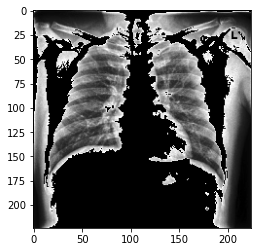

In [10]:
plt.imshow(lungs, cmap='gray');

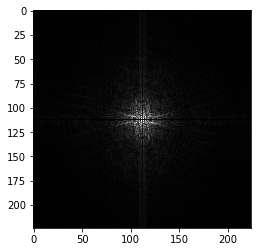

In [12]:
_, filtered_image, _, _ = godec(image, rank=5, max_iter=20)
f = cv2.dft(filtered_image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
f = np.fft.fftshift(f)
f = f[:, :, 0]*1j + f[:, :, 1]

plt.imshow(np.abs(f), cmap='gray');

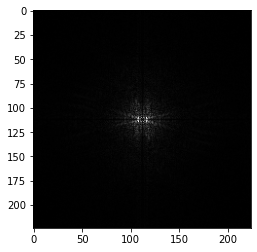

In [13]:
_, filtered_image, _, _ = godec(image, rank=5, max_iter=20)
f = cv2.dft(filtered_image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
f = np.fft.fftshift(f)
f_real = hpf(f[:, :, 1], 5)
f_img = hpf(f[:, :, 0], 5)

f = f_img*1j + f_real

plt.imshow(np.abs(f), cmap='gray');

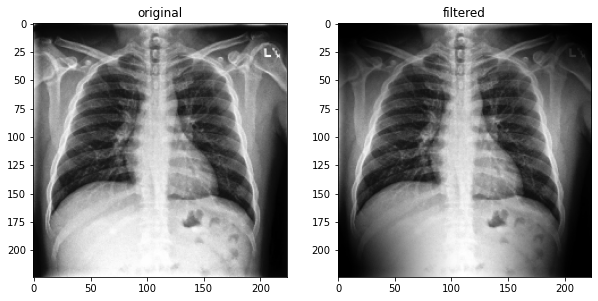

In [11]:
#_, gimage, _, _ = godec(image)
show_results(image, fourier(image))

In [83]:
smsm_filt = image.copy()
smsm_filt[smsm_filt<170], smsm_filt[smsm_filt>=170] = 0, 255

atl_filt = ~smsm_filt.copy()
atl_filt[atl_filt==255] = 1
atls = image*atl_filt

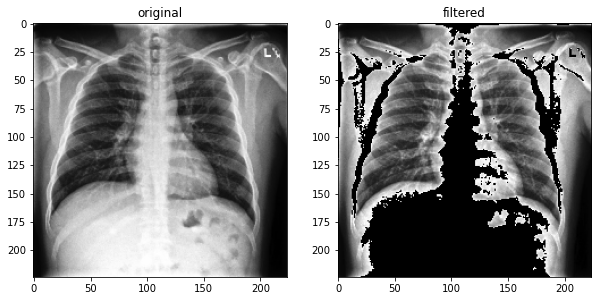

In [84]:
show_results(image, atls)

In [85]:
zeco_filt = image.copy()
zeco_filt[(zeco_filt<170)], zeco_filt[zeco_filt>=170] = 0, 255

lungs_filt = ~zeco_filt.copy()
lungs_filt[lungs_filt==255] = 1
lungs = image*lungs_filt

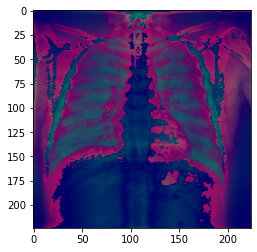

In [86]:
image_rgb = np.zeros((224, 224, 3)).astype(int)
image_rgb[:,:,0] = lungs
image_rgb[:,:,1] = fourier(image)
image_rgb[:,:,2] = 100

plt.imshow(image_rgb);

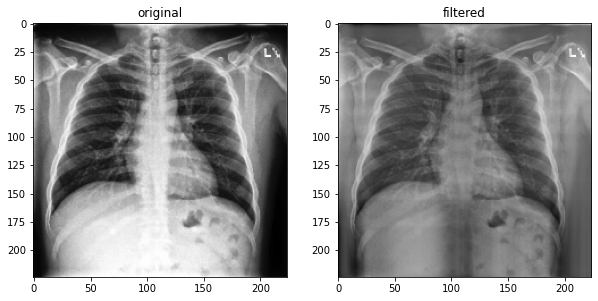

In [126]:
_, im, _, _ = godec(image)

show_results(image, im)

## Patients

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('../../../../Data/CheXpert-v1.0-small/train.csv')

In [17]:
data.loc[:, data.columns[5:]] = data.loc[:, data.columns[5:]].fillna(0)

zeros = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']
data.loc[:, zeros] = data.loc[:, zeros].replace({-1:0})
ones = ['Edema', 'Atelectasis']
data.loc[:, ones] = data.loc[:, ones].replace({-1:1})

data = data[['Path', 'Frontal/Lateral', 'Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']].copy() 

In [3]:
data.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [15]:
data['patient'] = data['Path'].str.split('/', expand=True).iloc[:, 2]

In [16]:
data['patient'].nunique()

64540

## dataset Exporation

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../../../../Data/CheXpert-v1.0-small/train.csv')

In [3]:
data.loc[:, data.columns[5:]] = data.loc[:, data.columns[5:]].fillna(0)

In [4]:
data_U = data.copy()
data_U.loc[:, data_U.columns[5:]] = data_U.loc[:, data_U.columns[5:]].replace({-1:'U', 0:'T', 1:'T'})

In [5]:
data_U.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,T,T,T,T,T,T,T,T,T,T,T,T,T,T
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,T,T,U,T,T,U,U,T,U,T,U,T,T,T
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,T,T,T,T,T,T,U,T,T,T,T,T,T,T
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,T,T,T,T,T,T,U,T,T,T,T,T,T,T
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,T,T,T,T,T,T,T,T,T,T,T,T,T,T


In [6]:
count = []

diseases = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']
for d in diseases:
    count.append(data_U[d].value_counts())

test = pd.concat(count, axis=1)

In [7]:
test = test.iloc[[1, 0], :]

In [8]:
test

,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
U,8087,12984,27742,33739,11628
T,215327,210430,195672,189675,211786


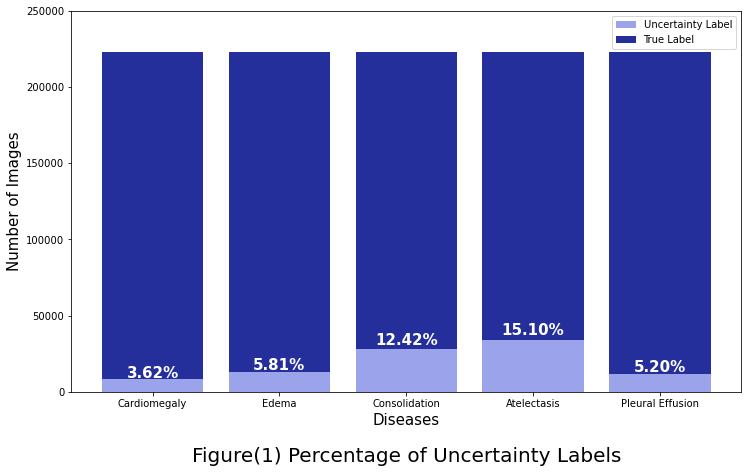

In [9]:
plt.figure(figsize=(12, 7))
plt.bar(x=test.columns, height=test.iloc[0, :], color='#9BA3EB', label='Uncertainty Label')
ax = plt.bar(x=test.columns, height=test.iloc[1, :], bottom=test.iloc[0, :], color='#242F9B', label='True Label')

n_images = test['Cardiomegaly'].sum()
for p in ax.patches:
    x_loc  = p.get_x()
    y_loc  = p.get_y()
    height = p.get_height()
    width  = p.get_width()
    pct    = '{:0.2f}%'.format(100*y_loc/n_images)

    # Adding the exact height at the top
    plt.text(x_loc+width/2, y_loc*1.1 , str(pct), weight = 'bold', ha="center", fontsize=15, color='#FFFFFF')
    
plt.title('Figure(1) Percentage of Uncertainty Labels', fontsize=20, y=-0.2)
plt.ylabel('Number of Images', fontsize=15)
plt.yticks([0, 50000, 100000, 150000, 200000, 250000], [0, 50000, 100000, 150000, 200000, 250000])
plt.xlabel('Diseases', fontsize=15)
plt.legend()
plt.savefig('Percentage of Uncetanty Labels', bbox_inches='tight');

In [14]:
data_imputed = data.copy()

data_imputed.loc[:, data_imputed.columns[5:]] = data_imputed.loc[:, data_imputed.columns[5:]].fillna(0)

zeros = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']
data_imputed.loc[:, zeros] = data_imputed.loc[:, zeros].replace({-1:0})
ones = ['Edema', 'Atelectasis']
data_imputed.loc[:, ones] = data_imputed.loc[:, ones].replace({-1:1})

In [16]:
data_imputed.groupby('Frontal/Lateral')['Pleural Effusion'].value_counts()

Frontal/Lateral  Pleural Effusion
Frontal          0.0                 114128
                 1.0                  76899
Lateral          0.0                  23099
                 1.0                   9288
Name: Pleural Effusion, dtype: int64

In [11]:
# card_data = pd.DataFrame({'Frontal':[12.24, 87.76], 'Lateral':[11.16, 88.84]})
# edema_data = pd.DataFrame({'Frontal':[32.19, 67.81], 'Lateral':[11.54, 88.46]})
# cons_data = pd.DataFrame({'Frontal':[6.8, 93.2], 'Lateral':[5.56, 94.44]})
# atl_data = pd.DataFrame({'Frontal':[31.19, 68.81], 'Lateral':[23.26, 76.74]})
# pe_data = pd.DataFrame({'Frontal':[40.26, 59.74], 'Lateral':[28.68, 71.32]})

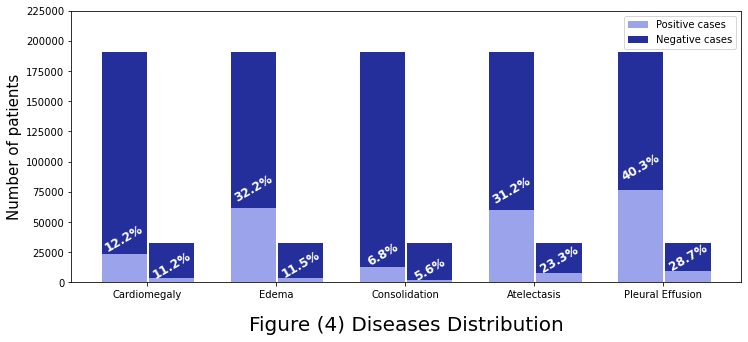

In [22]:
card_data = pd.DataFrame({'Frontal':[23385, 167642], 'Lateral':[3615, 28772]})
edema_data = pd.DataFrame({'Frontal':[61493, 129534], 'Lateral':[3737, 28650]})
cons_data = pd.DataFrame({'Frontal':[12983, 178044], 'Lateral':[1800, 30587]})
atl_data = pd.DataFrame({'Frontal':[59583, 131444], 'Lateral':[7532, 24855]})
pe_data = pd.DataFrame({'Frontal':[76899, 114128], 'Lateral':[9288, 23099]})

plt.figure(figsize=(12, 5))
test = pd.concat([card_data, edema_data, cons_data, atl_data, pe_data], axis=1)
for i in range(5):
    plt.bar(x=[0+2*i, 0.73+2*i], height=test.iloc[0, i*2:2*(i+1)], width=0.7, color='#9BA3EB', 
            label='Positive cases'  if (i-3)>0 else None)
    ax = plt.bar(x=[0+2*i, 0.73+2*i], height=test.iloc[1, i*2:2*(i+1)], bottom=test.iloc[0, i*2:2*(i+1)], 
                 width=0.7, color='#242F9B', label='Negative cases'  if (i-3)>0 else None)

    for p in ax.patches:
        x_loc  = p.get_x()
        y_loc  = p.get_y()
        height = p.get_height()
        width  = p.get_width()
        pct    = '{:0.1f}%'.format(100*y_loc/(y_loc+height))

        # Adding the exact height at the top
        plt.text(x_loc+width/2, y_loc*1.1 , str(pct), weight = 'bold', ha="center", fontsize=12, 
                 color='#FFFFFF', rotation=30)

plt.title('Figure (4) Diseases Distribution', fontsize=20, y=-0.2)
plt.xticks([0.35, 2.35, 4.35, 6.35, 8.35], diseases)
plt.ylabel('Number of patients', fontsize=15)
plt.yticks(range(0, 250000, 25000), range(0, 250000, 25000))
plt.legend()
plt.savefig('Diseases Distribution', bbox_inches='tight');

In [11]:
amr_data = data.copy()
l = amr_data[amr_data['Sex']=='Unknown'].index
amr_data.drop(index=l,inplace=True)

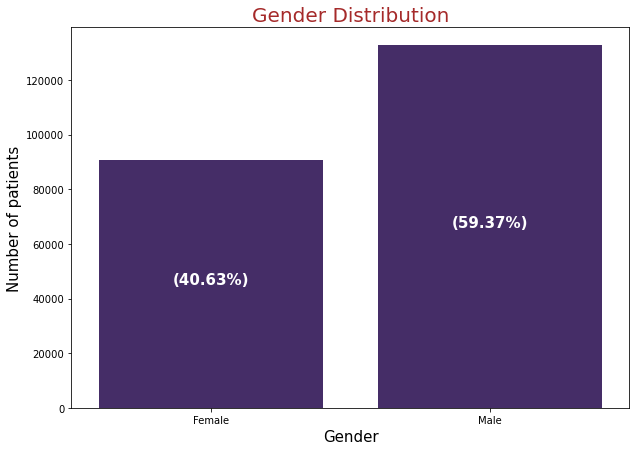

In [14]:
plt.figure(figsize=(10,7))

ax = sns.countplot(data=amr_data, x='Sex', palette=['#432371','#432371'])

n_images = amr_data.shape[0]
for p in ax.patches:
    loc    = p.get_x()
    height = p.get_height()
    width  = p.get_width()
    pct    = '({:0.2f}%)'.format(100*height/n_images)

    # Adding the percentage wrt the total number of clients at the middle of each column
    ax.text(loc+width/2, int(0.5*height), pct, weight = 'bold',ha="center", fontsize=15, color='w')
    
plt.title('Gender Distribution', fontsize=20, color='brown')
plt.xlabel('Gender', fontsize=15)
plt.ylabel('Number of patients', fontsize=15)
plt.savefig('Gender Distribution');

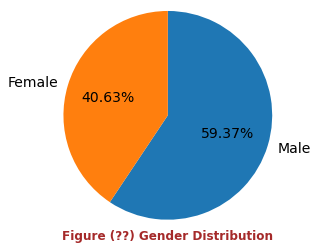

In [15]:
val_count = amr_data['Sex'].value_counts()
plt.pie(x=val_count.values, labels=val_count.index, startangle=90, counterclock=False, autopct='%0.2f%%', radius=1.2, 
        textprops={'fontsize':14});

plt.title('Figure (??) Gender Distribution', fontsize=12, weight='bold', color='brown', y=-0.1)
plt.savefig('Gender Distribution', bbox_inches='tight');

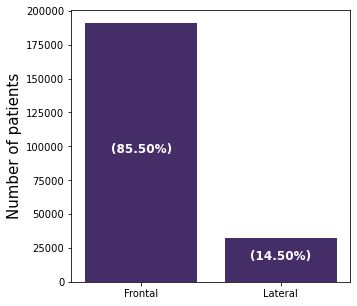

In [16]:
plt.figure(figsize=(5,5))

ax = sns.countplot(data=amr_data, x='Frontal/Lateral', palette=['#432371','#432371'])

n_images = amr_data.shape[0]
for p in ax.patches:
    loc    = p.get_x()
    height = p.get_height()
    width  = p.get_width()
    pct    = '({:0.2f}%)'.format(100*height/n_images)

    # Adding the percentage wrt the total number of clients at the middle of each column
    ax.text(loc+width/2, int(0.5*height), pct, weight = 'bold',ha="center", fontsize=12, color='w')

plt.xlabel('')
plt.ylabel('Number of patients', fontsize=15)
plt.savefig('Frontal-Lateral Distribution', bbox_inches='tight')

In [17]:
amr_data.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


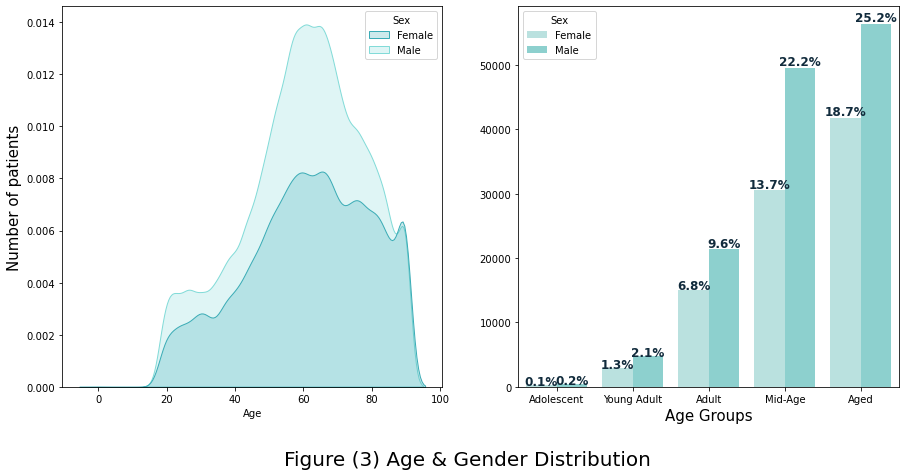

In [21]:
fig = plt.figure(figsize=(15,7))
fig.suptitle('Figure (3) Age & Gender Distribution', fontsize=20, y=-0.00001)

ax = plt.subplot(121)

sns.kdeplot(data=amr_data, x='Age', hue='Sex', shade=True, palette=['#3BACB6', '#82DBD8'], ax=ax)

plt.ylabel('Number of patients', fontsize=15);



ax = plt.subplot(122)
age_gen = amr_data[['Age', 'Sex']].copy()
age_gen['Age'] = pd.cut(x=amr_data['Age'], bins=[0, 18, 24, 45, 64, 95], 
                  labels=['Adolescent', 'Young Adult', 'Adult', 'Mid-Age', 'Aged'])

# palette=['#CCF3EE', '#B3E8E5', '#82DBD8', '#3BACB6','#2F8F9D']
ax = sns.countplot(data=age_gen, x='Age', hue='Sex', palette=['#B3E8E5', '#82DBD8'], ax=ax)

n_images = amr_data.shape[0]
for p in ax.patches:
    loc    = p.get_x()
    height = p.get_height()
    width  = p.get_width()
    pct    = '{:0.1f}%'.format(100*height/n_images)

    # Adding the percentage wrt the total number of clients at the middle of each column
    ax.text(loc+width/2, int(1.01*height), pct, weight='bold', ha="center", fontsize=12, color='#112B3C')

plt.ylabel('');
plt.xlabel('Age Groups', fontsize=15)
plt.savefig('Age & Gen Distribution', bbox_inches='tight');

In [83]:
amr_data['Age'].min()

0

In [84]:
amr_data['Age'].max()

90

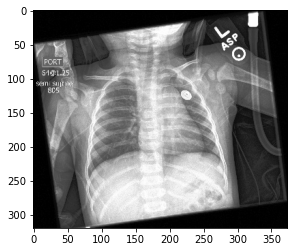

In [91]:
plt.imshow(plt.imread('D:\Graduation Project\Data\\'+amr_data[amr_data['Age']==0]['Path'].iloc[2]), cmap='gray');

In [1]:
import pandas as pd

In [2]:
val = pd.read_csv('../../../../Data/CheXpert-v1.0-small/valid.csv')

In [4]:
val.shape

(234, 19)

In [5]:
val.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
val.iloc[0, 0]

'CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg'

In [14]:
val['Path'].str.split('/', expand=True).iloc[:, 2].nunique()

200